In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.datacollection import DataCollector


In [16]:
class VoterAgent(CellAgent): 
    """ Voter agent with a party preference. """

    def __init__(self, model, cell):
        super().__init__(model)
        self.political_opinion = np.random.choice([0, 1])
        self.political_bias = np.random.uniform(0, 100) ## 
        self.susceptibility = np.random.uniform(0, 1)
        self.switched_this_step = False
        self.has_interacted = False
        self.cell = cell

    def move(self):
        """ Move to a random neighboring cell. """    
        self.cell = self.cell.neighborhood.select_random_cell()

    def evaluate_opinion(self):
        """ Evaluate and possibly change political opinion. """
        if self.political_bias < 50:
            self.political_opinion = 0
        else: 
            self.political_opinion = 1

    def mutual_persuasion(self, other):
        """Both agents are moderately open: they compromise."""
        delta = min(self.susceptibility, other.susceptibility)
        new_self_bias = self.political_bias + delta * (other.political_bias - self.political_bias)
        new_other_bias = other.political_bias + delta * (self.political_bias - other.political_bias)
        return new_self_bias, new_other_bias


    def p2_convinces_p1(self, other):
        """Self is open, other is stubborn: self moves toward other, other reinforces."""
        new_self_bias = self.political_bias + self.susceptibility * (other.political_bias - self.political_bias)
        new_other_bias = other.political_bias + other.susceptibility * (other.political_bias - 50)
        return new_self_bias, new_other_bias


    def p1_convinces_p2(self, other):
        """Self is stubborn, other is open: other moves toward self, self reinforces."""
        new_other_bias = other.political_bias + other.susceptibility * (self.political_bias - other.political_bias)
        new_self_bias = self.political_bias + self.susceptibility * (self.political_bias - 50)
        return new_self_bias, new_other_bias


    def disagreement(self, other):
        """Both are stubborn: they push away from each other."""
        new_self_bias = self.political_bias + (1 - self.susceptibility) * (self.political_bias - other.political_bias)
        new_other_bias = other.political_bias + (1 - other.susceptibility) * (other.political_bias - self.political_bias)
        return new_self_bias, new_other_bias

    def choose_rule(self, other):
        """Decide which interaction rule to apply based on susceptibility."""
        if self.susceptibility > 0.3 and other.susceptibility > 0.3:
            return "mutual"
        elif self.susceptibility > 0.7 and other.susceptibility < 0.3:
            return "p2convince"
        elif self.susceptibility < 0.3 and other.susceptibility > 0.7:
            return "p1convince"
        else:
            return "disagree"
    
    # dictionary to define interaction rules
    interaction_rules = {
    "mutual": mutual_persuasion,
    "p2convince": p2_convinces_p1,
    "p1convince": p1_convinces_p2,
    "disagree": disagreement,
    }

    def policy_influence(self, other):
        rule = self.choose_rule(other)
        new_self_bias, new_other_bias = self.interaction_rules[rule](self, other)

        # bounding between 0 - 100
        self.political_bias = max(0, min(100, new_self_bias))
        other.political_bias = max(0, min(100, new_other_bias))

    def media_influence(self, media_bias):
        """ Influence from media. """
        self.political_bias = self.political_bias + self.susceptibility * media_bias

    def interact(self):
        """ Interact with other agents in the same cell. """
        if self.has_interacted: 
            return

        others = [agent for agent in self.cell.agents if agent != self and not agent.has_interacted]
        if others:
            other = self.random.choice(others)
            self.policy_influence(other)
            # mark both as having interacted
            self.has_interacted = True
            other.has_interacted = True


        previous_opinion = self.political_opinion
        self.evaluate_opinion()
        self.switched_this_step = (self.political_opinion != previous_opinion)

    def reset(self):
        """ At the beginning of a step, no agent has interacted. """
        # Reset interaction flags for all agents at the start of this step
        for agent in self.agents:
            agent.has_interacted = False

In [6]:
def mean_bias(model):
    return np.mean([a.political_bias for a in model.agents])

def var_bias(model):
    return np.var([a.political_bias for a in model.agents])

def switching_rate(model):
    # fraction of agents that switched this step
    vals = [getattr(a, "switched_this_step", False) for a in model.agents]
    return float(np.mean(vals))

# import networkx as nx

# def share_red(model):
#    vals = [a.political_opinion for a in model.schedule.agents]
#    return float(np.mean(vals))  # if Red=1, Blue=0

# def neighbor_disagreement(model):
#    G = model.graph
#    diffs = []
#    for a in model.schedule.agents:
#        nbrs = list(G.neighbors(a.pos)) if hasattr(a, "pos") else []
#        if not nbrs:
#            continue
#        nbr_bias = np.mean([b.political_bias for b in model.net_grid.get_cell_list_contents(nbrs)])
#        diffs.append(abs(a.political_bias - nbr_bias))
#    return float(np.mean(diffs)) if diffs else 0.0

#def assortativity_by_opinion(model):
    # Requires node attribute 'opinion' on graph nodes each step
    # For NetworkGrid, map agent state to node attribute then use attribute assortativity:
#    for node in model.graph.nodes:
#        agents = model.net_grid.get_cell_list_contents([node])
#        model.graph.nodes[node]['opinion'] = int(np.round(np.mean([ag.political_opinion for ag in agents]))) if agents else 0
    # Using degree assortativity is built-in; for attributes, compute mixing matrices or use net libs.
    # Here: fallback—compute degree assortativity as a proxy:
#    return float(nx.degree_assortativity_coefficient(model.graph))

#def modularity_same_opinion(model):
    # Simple community partition by majority opinion per node
#    comms = {}
#    for node in model.graph.nodes:
#        o = model.graph.nodes[node].get('opinion', 0)
#        comms.setdefault(o, set()).add(node)
#    communities = [c for c in comms.values() if c]
#    if len(communities) <= 1:
#        return 0.0
#    try:
#        import networkx.algorithms.community as nxcom
#        return float(nxcom.quality.modularity(model.graph, communities))
#    except Exception:
#        return 0.0

In [ ]:
class Environment(mesa.Model):
    """ Environment with a grid of cells. """

    def __init__(self, n, width, height, seed=None):
        super().__init__()
        self.seed = seed
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), 
            torus=True, 
            capacity=10, 
            random=self.random
        )

        VoterAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = DataCollector(
            model_reporters={
                "mean_bias": mean_bias,
                "var_bias": var_bias,
                "switching_rate": switching_rate,
            },
            agent_reporters={
                "political_bias": lambda a: a.political_bias,
                "political_opinion": lambda a: a.political_opinion,
                "susceptibility": lambda a: a.susceptibility,
                "switched":  lambda a: getattr(a, "switched_this_step", False),
            },
        )

        self.datacollector.collect(self)


    def step(self):
        """ Advance the model by one step. """
        self.agents.shuffle_do("move")
        self.agents.do("reset")
        self.agents.do("interact")
        self.datacollector.collect(self)

    def media_campaign(self, bias):
        """ Conduct a media campaign with a specific bias. """
        self.agents.do("media_influence", bias)
        

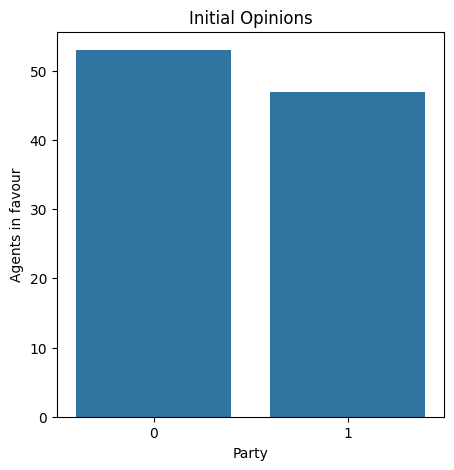

In [10]:
environment = Environment(100, 10, 10)

initial_votes = [agent.political_opinion for agent in environment.agents]
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Opinions", xlabel="Party", ylabel="Agents in favour")
p.figure.set_size_inches(5, 5)

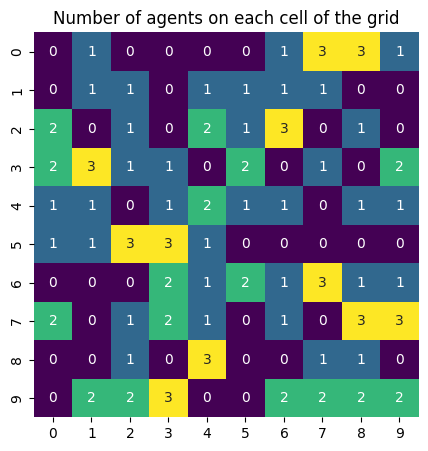

In [8]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

In [9]:
for _ in range(100):
    environment.step()  
    #if _ == 50:
    #    environment.media_campaign(bias=50)

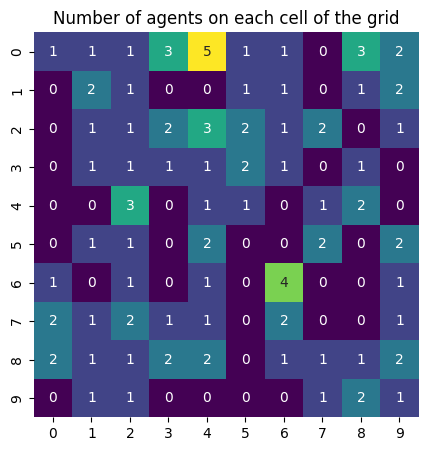

In [10]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

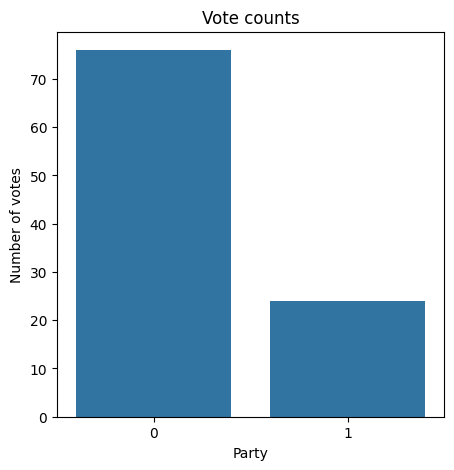

In [11]:
all_votes = [agent.political_opinion for agent in environment.agents]
vote_counts = pd.Series(all_votes).value_counts().sort_index()
g = sns.barplot(x=vote_counts.index, y=vote_counts.values)
g.set(title="Vote counts", xlabel="Party", ylabel="Number of votes")
g.figure.set_size_inches(5, 5)


In [12]:
model_df = environment.datacollector.get_model_vars_dataframe()
agent_df = environment.datacollector.get_agent_vars_dataframe()


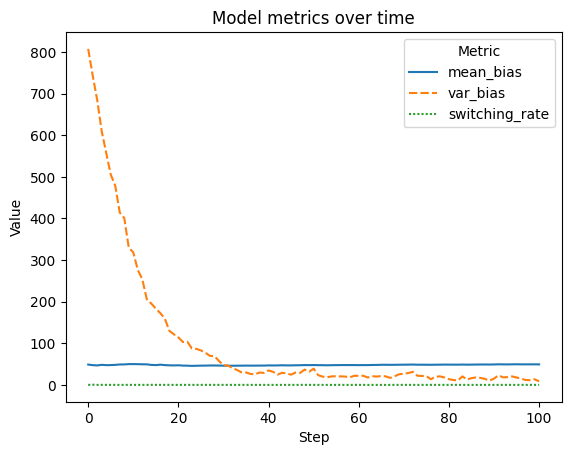

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Or to plot several metrics at once (if you have them):
sns.lineplot(data=model_df)  # will plot each column separately
plt.title("Model metrics over time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend(title="Metric")
plt.show()

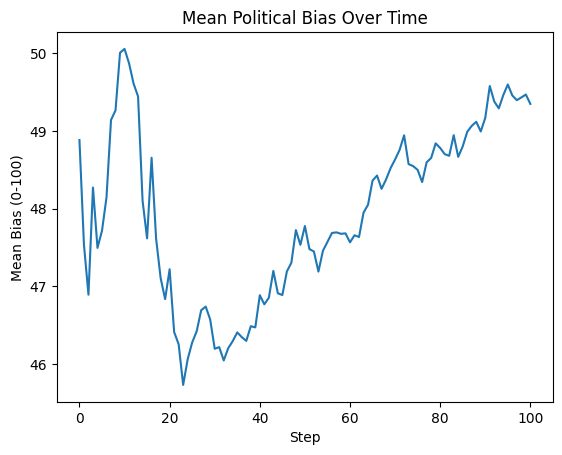

In [14]:
# If you want just one metric (e.g. mean_bias) over time:
sns.lineplot(data=model_df["mean_bias"])
plt.title("Mean Political Bias Over Time")
plt.xlabel("Step")
plt.ylabel("Mean Bias (0-100)")
plt.show()

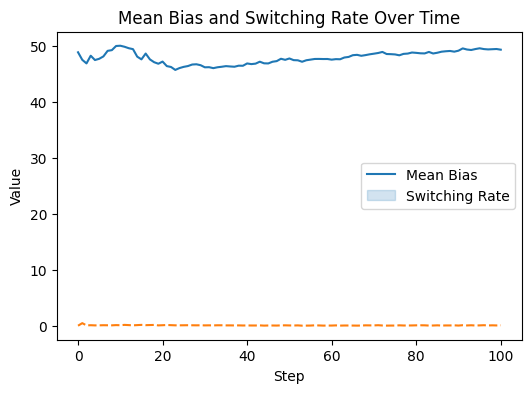

In [15]:
# Or plot both together
plt.figure(figsize=(6,4))
sns.lineplot(data=model_df[["mean_bias", "switching_rate"]])
plt.title("Mean Bias and Switching Rate Over Time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend(["Mean Bias", "Switching Rate"])
plt.show()